In [16]:
# Import all dependencies
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Define basic image parameters
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
DATA_DIR = 'datasets/city_landscapes/'

In [8]:
train_image_folder = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

# Load the data
train_data_loader = DataLoader(train_image_folder, batch_size=batch_size, shuffle=True, num_workers=3,
                               pin_memory=True)

In [11]:
# Function for denormalizing image tensors
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [14]:
# Function that shows images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

# Function that shows batch of images
def show_batch(data_loader, nmax=64):
    for images, _ in data_loader:
        show_images(images, nmax)
        break

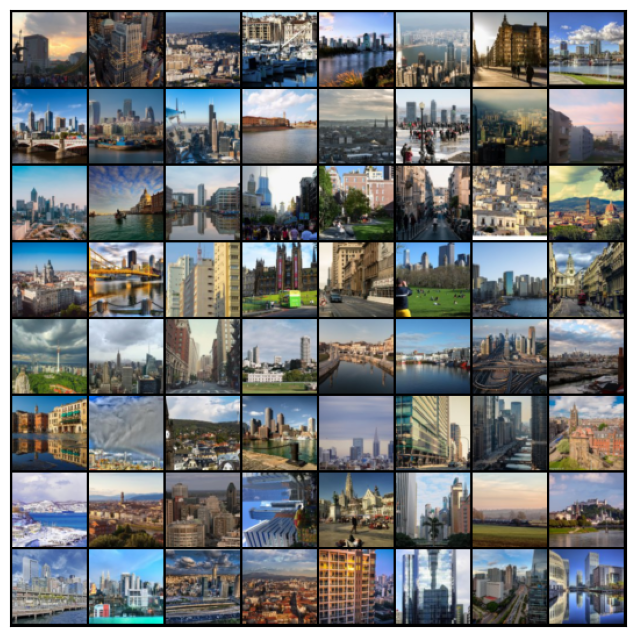

In [15]:
# Show 64 images (1 batch) from training data loader
show_batch(train_data_loader)

In [17]:
# Set up a proper device (in our case - GPU)
def get_default_device():
    
    # GPU if available, else choose CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Move any tensor to chosen device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    # Wrap a dataloader to move data to a device
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
    
    # Yield a batch of data after moving it to device
    def __iter__(self):
        for b in self.data_loader:
            yield to_device(b, self.device)
    
    # Get number of batches
    def __len__(self):
        return len(self.data_loader)

In [18]:
# Set up a device, "cuda" (GPU) in our case
device = get_default_device()
device

device(type='cuda')

In [19]:
# Move our training data loader to our device of use
train_data_loader = DeviceDataLoader(train_data_loader, device)